**This Notebook gives some example of Performance metric for Classification and Regression Task. </br>**

<ol>
  <ul>
    <li> 
    Classificiation
      <ol>
        <li>
           Highly Imbalanced Data ( Positive points >>>>> Negative Points)
          </li>
          <li>
            Highly Imbalanced Data ( Negative  points >>>>> Positive  Points)
          </li>
          <li>
            Almost Balanced Data ( Used custom Metric to Penalized False Negative Rate)
          </li>
        </ol>
      </li>  
      <li>
      Regression Case
      
      
  </ul>
</ol>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Applied_AI/Performance\ Matrix


/content/drive/MyDrive/Applied_AI/Performance Matrix


In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm 
# other than these two you should not import any other packages

<pre>
<font color='red'><b>A.</b></font> Compute performance metrics for the given data <strong>5_a.csv</strong>
   <b>Note 1:</b> in this data you can see number of positive points >> number of negatives points
   <b>Note 2:</b> use pandas or numpy to read the data from <b>5_a.csv</b>
   <b>Note 3:</b> you need to derive the class labels from given score</pre> $y^{pred}= \text{[0 if y_score < 0.5 else 1]}$

<pre>
<ol>
<li> Compute Confusion Matrix </li>
<li> Compute F1 Score </li>
<li> Compute AUC Score, you need to compute different thresholds and for each threshold compute tpr,fpr and then use               numpy.trapz(tpr_array, fpr_array) <a href='https://stackoverflow.com/q/53603376/4084039'>https://stackoverflow.com/q/53603376/4084039</a>, <a href='https://stackoverflow.com/a/39678975/4084039'>https://stackoverflow.com/a/39678975/4084039</a> Note: it should be numpy.trapz(tpr_array, fpr_array) not numpy.trapz(fpr_array, tpr_array)</li>
<li> Compute Accuracy Score </li>
</ol>
</pre>

In [5]:
"""
Class to get confusion matrix from true and predicted labels .
This is only for Binary Classfication Problem.
This is very basic class defination. Validation is not performed.
"""
class ConfusionMatrix(object):

  def __init__(self, data) :
    
    self.data = data
    self.tp = None
    self.tn  = None
    self.fp = None
    self.fn = None
    self.recall = None
    self.precision = None
    self.tpr = None
    self.fpr = None
    self.accuracy = None
    
  
  def getTruePositive(self) :
    self.tp  =  np.count_nonzero(np.logical_and(self.data["pred_y"] ==  1 ,  self.data["y"] == 1))  
    return self.tp
    

  def getTrueNegative(self):
    self.tn =   np.count_nonzero(np.logical_and(self.data["pred_y"] ==  0 ,  self.data["y"] == 0))  
    return self.tn

  def getFalsePositive(self):
    self.fp =  np.count_nonzero(np.logical_and(self.data["pred_y"] ==  1 ,  self.data["y"] == 0)) 
    return self.fp 


  def getFalseNegative(self):
    self.fn =  np.count_nonzero(np.logical_and(self.data["pred_y"] ==  0 ,  self.data["y"] == 1))
    return self.fn

  def getRecall(self) :
    if self.tp is None or self.fn is None :
      self.getTruePositive()
      self.getFalseNegative()
    self.recall = self.tp / (self.tp + self.fn)
    self.tpr = self.recall
    return self.recall

  def getPrecision(self) :
    if self.tp is None or self.fp is None :
      self.getTruePositive()
      self.getFalsePositive()
    self.precision = self.tp / (self.tp + self.fp)
    return self.precision

  def getTruePositiveRate(self) :
    return self.getRecall()

  def getFalsePositiveRate(self):
    if self.fp is None or self.tn is None:
      self.getFalsePositive()
      self.getTrueNegative()
    self.tpr = self.fp / (self.fp + self.tn)
    return self.tpr

  def getAccuracy(self) :
    if self.tp  is None or self.tn is None:
      self.getTruePositive()
      self.getTrueNegative()
    return (self.tp + self.tn) / self.data["y"].count()
  





***Case 1 ***</br> 
**Performance matrix on highly imbalanced data**  </br>

**10000 positive points** </br>

**100 negative points** </br> 

In [6]:


data1 =  pd.read_csv("5_a.csv")
print(data1.columns)
data1["y"].value_counts()
# data is highly imbalanced
# positive points to negative point ratio is 100 : 1


Index(['y', 'proba'], dtype='object')


1.0    10000
0.0      100
Name: y, dtype: int64

In [7]:
# f1 score 
# f1 score is harmonic mean of precision and recall

def getF1Score(precison, recall) :
  return 2 /( (1/precison ) + (1/recall))  

In [8]:
# let's predict y based on probability score given in the data
# if proba > 0.5 :
#   y_pred = 1
# else :
#   y_predd = 0
data1["pred_y"] = np.where(data1["proba"] < 0.5, 0, 1 )



In [9]:
# Confusion Matrix
cm   = ConfusionMatrix(data1)
tp = cm.getTruePositive()
fp = cm.getFalsePositive()
tn = cm.getTrueNegative()
fn  = cm.getFalseNegative()
print("true positive : {}, false positive : {} , true Negative : {}, false Negative : {}".format(tp, fp, tn, fn))

true positive : 10000, false positive : 100 , true Negative : 0, false Negative : 0


In [11]:
# f1 score
recall = cm.getRecall()

precision = cm.getPrecision()
f1Score = getF1Score(precision, recall)
print("Recall : {}, Precision : {}, F1score : {} ".format(recall, precision, f1Score))


Recall : 1.0, Precision : 0.9900990099009901, F1score : 0.9950248756218907 


In [12]:
# Accuracy score
accuracy = cm.getAccuracy()
print("accuracy : {} ".format(accuracy))

accuracy : 0.9900990099009901 


In [13]:
# 4) AUC and ROC curve
class ROC(object) :
  def __init__(self, data, thresholdList) :
    self.data  = data
    self.thresholdList = thresholdList
    self.fprList = []
    self.tprList = []


  def getROCData(self ) :
    
    for tau in tqdm(self.thresholdList) :
      self.data["pred_y"] = np.where(self.data["proba"] < tau, 0, 1 )
      confusion = ConfusionMatrix(self.data)
      tpr = confusion.getTruePositiveRate()
      fpr = confusion.getFalsePositiveRate()
      self.fprList.append(fpr)
      self.tprList.append(tpr)
    
    return

  def gettprList(self):
    return sorted(self.tprList)

  def getfprList(self):
    return sorted(self.fprList)

  def getAUCValue(self) :
    if len(self.tprList ) == 0 or len(self.fprList) == 0 :
      self.getROCData()
    return np.trapz(sorted(self.tprList), sorted(self.fprList))

  



In [14]:
# 4) Computer AUC curve

#  for auc we need to get threshold so we will sort based on prob value
# then for each sorted prob vale will be used as threshold to predict based on threshold and 
# then we will plot all tpr and fpr calculated based on this threshold and calculate the are under ROC curve

sorted_data1 = data1.sort_values(by=['proba'])

In [ ]:
thresholdList = np.unique(sorted_data1["proba"]).tolist()
len(thresholdList)

In [ ]:
#Auc value
roc = ROC(sorted_data1, thresholdList)
print("AUC {} ".format( roc.getAUCValue()))

In [ ]:
# plot roc curve
import matplotlib.pyplot as plt
plt.plot(roc.tprList, roc.fprList)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


# Compute performance metrics for the given Y and Y_score without sklearn

<pre>
<font color='red'><b>B.</b></font> Compute performance metrics for the given data <strong>5_b.csv</strong>
   <b>Note 1:</b> in this data you can see number of positive points << number of negatives points
   <b>Note 2:</b> use pandas or numpy to read the data from <b>5_b.csv</b>
   <b>Note 3:</b> you need to derive the class labels from given score</pre> $y^{pred}= \text{[0 if y_score < 0.5 else 1]}$

<pre>
<ol>
<li> Compute Confusion Matrix </li>
<li> Compute F1 Score </li>
<li> Compute AUC Score, you need to compute different thresholds and for each threshold compute tpr,fpr and then use               numpy.trapz(tpr_array, fpr_array) <a href='https://stackoverflow.com/q/53603376/4084039'>https://stackoverflow.com/q/53603376/4084039</a>, <a href='https://stackoverflow.com/a/39678975/4084039'>https://stackoverflow.com/a/39678975/4084039</a></li>
<li> Compute Accuracy Score </li>
</ol>
</pre>

***Case 2 ***  </br>

positive points << number of negatives points </br> 
**Performance matrix on highly imbalanced data**  </br>

**10000 Negative points** </br>

**100 positive points** </br> 

In [15]:
# write your code here
data2 =  pd.read_csv("5_b.csv")
print(data1.columns)
data2["y"].value_counts()
# data is highly imbalanced
# positive points to negative point ratio is 100 : 1


Index(['y', 'proba', 'pred_y'], dtype='object')


0.0    10000
1.0      100
Name: y, dtype: int64

In [16]:
# let's predict y based on probability score given in the data
# if proba > 0.5 :
#   y_pred = 1
# else :
#   y_predd = 0
data2["pred_y"] = np.where(data2["proba"] < 0.5, 0, 1 )



In [17]:
# 1) confusion Matrix

cm   = ConfusionMatrix(data2)
tp = cm.getTruePositive()
fp = cm.getFalsePositive()
tn = cm.getTrueNegative()
fn  = cm.getFalseNegative()
fpr = cm.getFalsePositiveRate()
tpr = cm.getTruePositiveRate()
print("true positive : {}, false positive : {} , true Negative : {}, false Negative : {}".format(tp, fp, tn, fn))

true positive : 55, false positive : 239 , true Negative : 9761, false Negative : 45


In [18]:
# f1 score

recall = cm.getRecall()
precision = cm.getPrecision()
f1ScoreData2 = getF1Score(precision, recall)
f1ScoreData2
print("Recall : {}, Precision : {}, F1score : {} ".format(recall, precision, f1ScoreData2))


Recall : 0.55, Precision : 0.1870748299319728, F1score : 0.27918781725888325 


In [19]:
#Auc Curve
# 4) Computer AUC curve

#  for auc we need to get threshold so we will sort based on prob value
# then for each sorted prob vale will be used as threshold to predict based on threshold and 
# then we will plot all tpr and fpr calculated based on this threshold and calculate the are under ROC curve

sorted_data2 = data2.sort_values(by=['proba'])

# get Threshold values
thresholdList2 = np.unique(sorted_data2["proba"]).tolist()
len(thresholdList2)

#Auc value
roc2 = ROC(sorted_data2, thresholdList2)







In [23]:
# AUC

print("AUC {}".format(roc2.getAUCValue()))


AUC 0.9377570000000001


Text(0, 0.5, 'True Positive Rate')

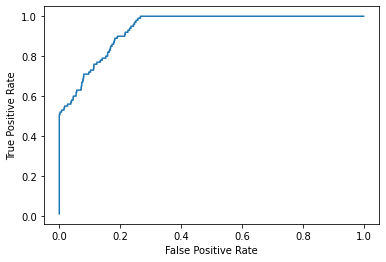

In [24]:
# plot roc curve
import matplotlib.pyplot as plt
plt.plot( (roc2.fprList), (roc2.tprList))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [22]:
# 4) Accuracy score

accuracy2 = cm.getAccuracy()
accuracy2

0.9718811881188119

<font color='red'><b>C.</b></font> Compute the best threshold (similarly to ROC curve computation) of probability which gives lowest values of metric <b>A</b> for the given data <strong>5_c.csv</strong>
<br>

you will be predicting label of a data points like this: $y^{pred}= \text{[0 if y_score < threshold  else 1]}$

$ A = 500 \times \text{number of false negative} + 100 \times \text{numebr of false positive}$

<pre>
   <b>Note 1:</b> in this data you can see number of negative points > number of positive points
   <b>Note 2:</b> use pandas or numpy to read the data from <b>5_c.csv</b>
</pre>

***Case 3  *** </br>

**Fairly Balanced Data :** </br> 


**1805 Negative points**

**1047 positive points**

We want to **penalized more False Negative**, because in this case buissness objective is to get lowest false negative numbers. for example this matrix is **critical in medical or clinical research**. You don't want to miss any potential patient. </br>

We will use custom metric which is defined as below : </br>


**$ A = 500 \times \text{number of false negative} + 100 \times \text{numebr of false positive}$ </br>** 

we will select threshold such that this **metrix is minimized.**



In [25]:
 # write your code

 data3 = pd.read_csv("5_c.csv")
 data3["y"].value_counts()

0    1805
1    1047
Name: y, dtype: int64

In [26]:
# we need to get threshold so we will sort based on prob value
# then for each sorted prob vale will be used as threshold to predict based on threshold and 
# then we will plot all tpr and fpr calculated based on this threshold and calculate the are under ROC curve

sorted_data3 = data3.sort_values(by=['prob'])

# get Threshold values
thresholdList3 = np.unique(sorted_data3["prob"]).tolist()
len(thresholdList3)


2791

In [27]:

# 4) AUC and ROC curve
class CustomMatrix(object) :
  def __init__(self, data, thresholdList) :
    self.data  = data
    self.thresholdList = thresholdList
    self.fprList = []
    self.tprList = []
    self.customMatrixValues = []


  def calculateMatrixValue(self ) :
    
    for tau in tqdm(self.thresholdList) :
      self.data["pred_y"] = np.where(self.data["prob"] < tau, 0, 1 )
      confusion = ConfusionMatrix(self.data)
      fp = confusion.getFalsePositive()
      fn = confusion.getFalseNegative()
      matricValue = (500 * fn ) + (100 * fp)
      self.customMatrixValues.append((tau, matricValue))
      
    
    return self.customMatrixValues

  

  




In [28]:
newmatric = CustomMatrix(data3, thresholdList3)
customMatrixValues = newmatric.calculateMatrixValue()


100%|██████████| 2791/2791 [00:05<00:00, 484.96it/s]


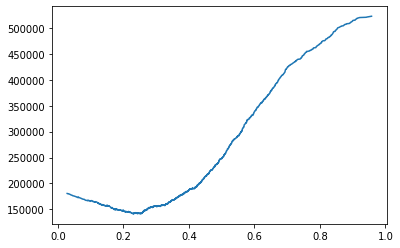

In [29]:
# create new data frame from list of tuple and set threshold as index
# get minimum matrix value threshold use idxmin method

newdf = pd.DataFrame(customMatrixValues, columns=['threshold', 'matrix']).set_index('threshold')

minThreshold = newdf[["matrix"]].idxmin()

plt.plot(*zip(*customMatrixValues))

In [30]:
print("Minimum Threshold Value : {}".format(minThreshold))

Minimum Threshold Value : matrix    0.230039
dtype: float64


<pre>
<font color='red'><b>D.</b></font> Compute performance metrics(for regression) for the given data <strong>5_d.csv</strong>
    <b>Note 2:</b> use pandas or numpy to read the data from <b>5_d.csv</b>
    <b>Note 1:</b> <b>5_d.csv</b> will having two columns Y and predicted_Y both are real valued features
<ol>
<li> Compute Mean Square Error </li>
<li> Compute MAPE: https://www.youtube.com/watch?v=ly6ztgIkUxk</li>
<li> Compute R^2 error: https://en.wikipedia.org/wiki/Coefficient_of_determination#Definitions </li>
</ol>
</pre>

Confusion Matrix is not a metric for regression problem.

We will use **Mean Square Error**, **Mean Absolute Percentage Error** for **Regression Problem**

In [31]:
data4 = pd.read_csv("5_d.csv")
meanError = np.mean(data4["y"])
data4["error"] = data4["y"] - data4["pred"]
data4["meanError"] = data4["y"] - meanError 
# 1) Mean Squared Error
MSE = np.mean(np.square(data4["error"]))
print( "Mean Squared Error", MSE)
SST = np.mean(np.square(data4["meanError"]))
print("Sum of Squared Total : ",SST)
# R^2 
R2 = 1 - (MSE/SST)
print( "R^2 value ",R2)

#MAPE
sumOfActualValue = np.sum(data4["y"])
sumOfErrors = np.sum(abs(data4["error"]))
MAPE = sumOfErrors/ (sumOfActualValue)
print('MAPE Value :', MAPE)

Mean Squared Error 177.16569974554707
Sum of Squared Total :  4059.54885518869
R^2 value  0.9563582786990964
MAPE Value : 0.1291202994009687
